In [3]:
!git clone https://github.com/sithu31296/semantic-segmentation
%pip install -U gdown
%pip install -e .
import gdown
from pathlib import Path

ckpt = Path('./checkpoints/pretrained/segformer')
ckpt.mkdir(exist_ok=True, parents=True)

url = 'https://drive.google.com/uc?id=1-OmW3xRD3WAbJTzktPC-VMOF5WMsN8XT'
output = './checkpoints/pretrained/segformer/segformer.b3.ade.pth'

gdown.download(url, output, quiet=False)

fatal: destination path 'semantic-segmentation' already exists and is not an empty directory.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/paolo/Downloads/magistrale/1%20anno/visiope/visiope/models
ERROR: file:///home/paolo/Downloads/magistrale/1%20anno/visiope/visiope/models does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import torch
import numpy as np
from torchvision import io
from torchvision import transforms as T
from PIL import Image
import pickle
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%cd semantic-segmentation

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope/models/semantic-segmentation


In [4]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -----------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  SegFormerppDDRNet
    6  FCHarDNet
    7  BiSeNetv2


In [2]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from semseg.models.base import BaseModel
from semseg.models.heads import SegFormerHead
from mitDecode import MiTDecode


class SegFormerpp(BaseModel):
    def __init__(self, backbone: str = 'MiT-B0', num_classes: int = 19, head: str = 'MiT-B0') -> None:
        super().__init__(backbone, num_classes)
        self.num_classes = num_classes
        self.head = head
        if head == 'custom':
            self.decode_head = MitDecode(head)
        else:
            self.decode_head = SegFormerHead(self.backbone.channels, 256 if 'B0' in backbone or 'B1' in backbone else 768, num_classes)
        
        self.apply(self._init_weights)

    def forward(self, x: Tensor) -> Tensor:
        y = self.backbone(x)
        y = self.decode_head(y)   # 4x reduction in image size
        #y = nn.Conv2d(x.shape[0],1,3)
        #y = torch.nn.LazyLinear(self.num_classes)
        if 'MiT' not in self.head:
            y = F.interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=False)    # to original image shape
        return y


if __name__ == '__main__':
    model = SegFormerpp('MiT-B0')
    # model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b0.ade.pth', map_location='cpu'))
    x = torch.zeros(1, 3, 512, 512)
    y = model(x)
    print(y.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 19, 128, 128])


In [3]:
#from semseg.models import *
#from segFormerpp import SegFormerpp

model = eval('SegFormerpp')(
    backbone='MiT-B3',
    num_classes=150
)

try:
    model.load_state_dict(torch.load('checkpointcheckpoints/pretrained/segformer/segformer.b3.ade.pth'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()
model.to(device)
print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [8]:
model.eval()

SegFormer(
  (backbone): MiT(
    (patch_embed1): PatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): PatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): PatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): PatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (kv): 

In [4]:

# Load the data loader from the pickle file

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class Ai4MarsData(Dataset):
    #X tensor (torch) -> images
    #y tensor (torch) -> labels

    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    #method used to split Dataset into 2 loader 
    def splitLoader(self,percentage,batch_size_train,batch_size_test):
        dataset = self
        ratio = percentage/100

        #setup variables
        d_size = len(self)
        train_size = int(ratio*d_size)
        test_size = d_size - train_size

        #split
        train_dataset, test_dataset = random_split(dataset,[train_size,test_size])

        #create other loaders
        train_loader = DataLoader(train_dataset,batch_size=batch_size_train)
        test_loader = DataLoader(test_dataset,batch_size=batch_size_test)
        return train_loader,test_loader
    


In [ ]:
!git clone https://github.com/airoprojects/visiope
with open('/content/drive/MyDrive/Dataset/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)


items = data_loader['dataloader'].dataset.__getitem__(1)


print(items[0].shape)


plt.imshow(items[0])
plt.show()

/home/paolo/Downloads/magistrale/1 anno/visiope/visiope
abstarct.pdf  gitsetup.ipynb  LICENSE  models/            README.md
dataloader/   latex/          loss/    project-managing/  test.ipynb


In [12]:
#local
with open('../../dataloader/data_loader.pkl', 'rb') as f:
    data_loader = pickle.load(f)


items = data_loader['dataloader'].dataset.__getitem__(1)

train_loader, test_loader = data_loader['dataloader'].dataset.splitLoader(80,1,1)

print(train_loader)


In [10]:
%ls

assests/      docs/       README.md               semseg/           tools/
checkpoints/  LICENSE     scripts/                semseg.egg-info/  visiope/
configs/      notebooks/  semantic-segmentation/  setup.py


In [8]:
loader = data_loader['dataloader'].dataset

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

def show_image(imgs):
    imgs = imgs.permute(2,0,1)
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

'''  
  print(img.device)
  print(img.shape)
  if (img.device != 'cpu'):
    img.to('cpu')
    print('test')
  print(img.device)
  plt.imshow(img)
  plt.show()
'''

"  \n  print(img.device)\n  print(img.shape)\n  if (img.device != 'cpu'):\n    img.to('cpu')\n    print('test')\n  print(img.device)\n  plt.imshow(img)\n  plt.show()\n"

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


/tmp/ipykernel_35197/1641144638.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)


torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1,

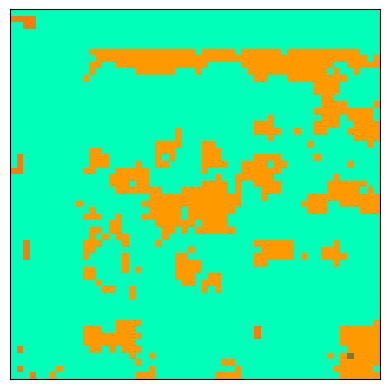

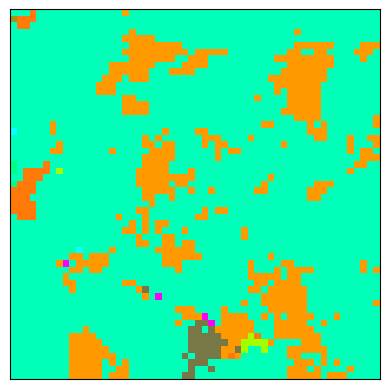

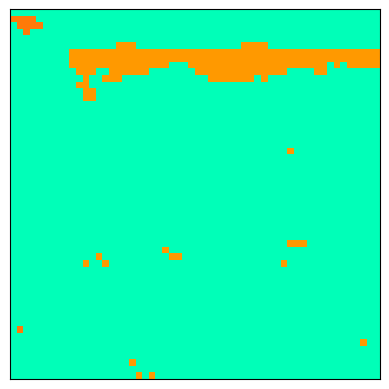

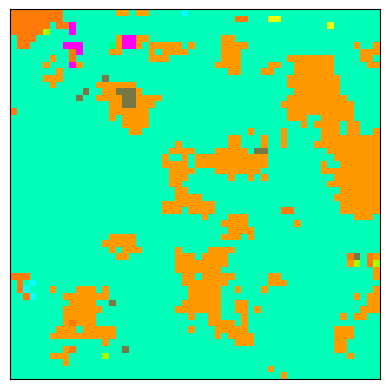

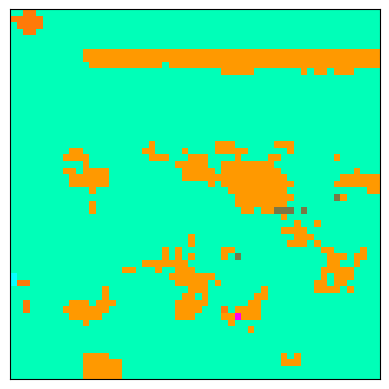

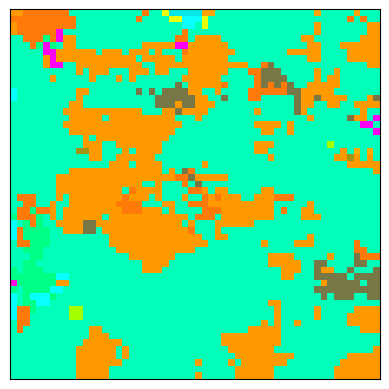

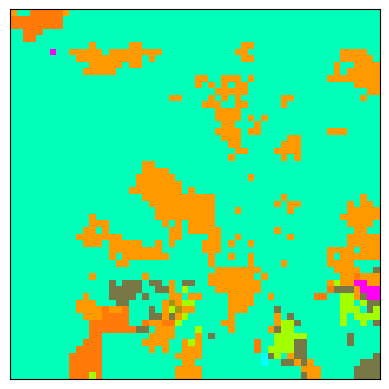

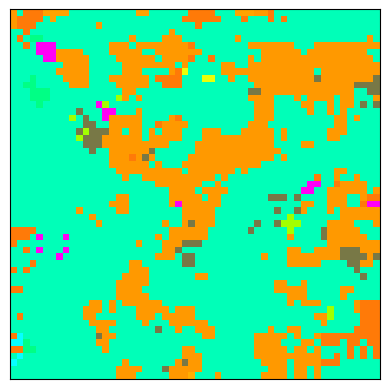

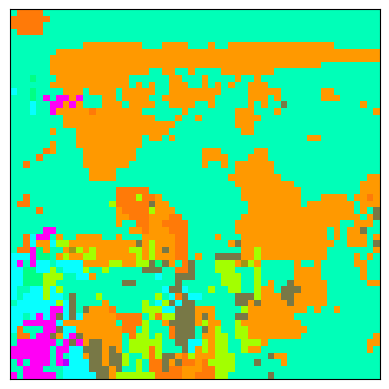

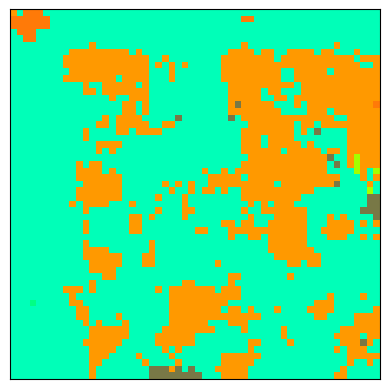

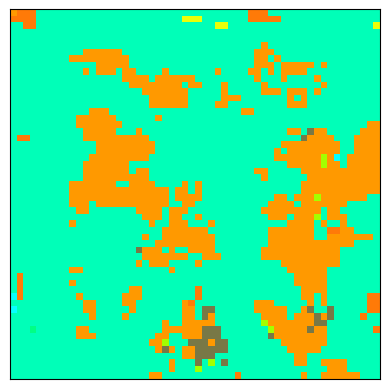

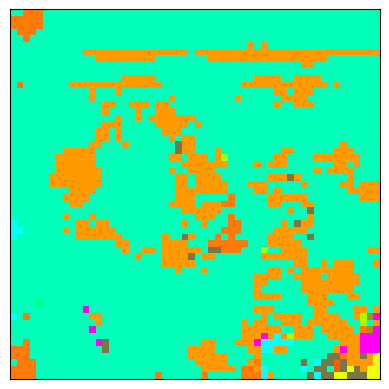

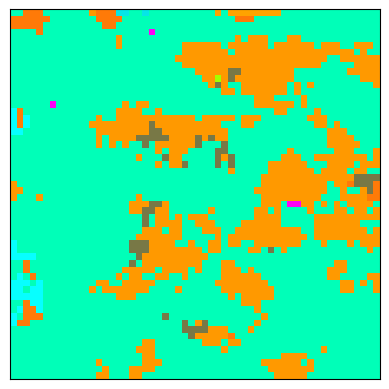

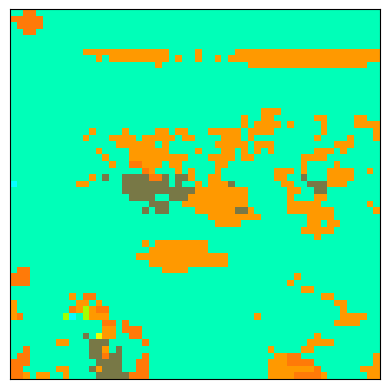

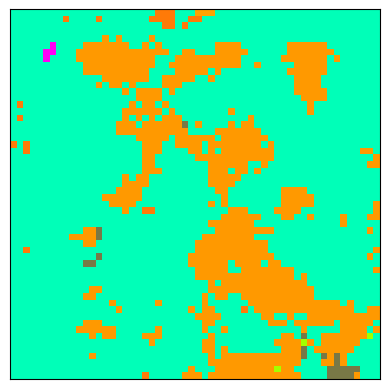

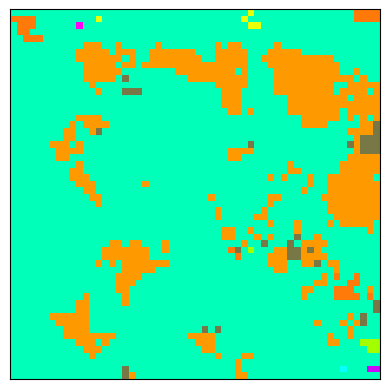

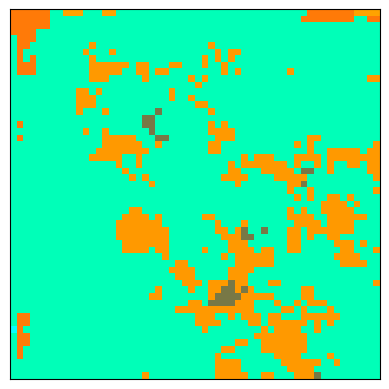

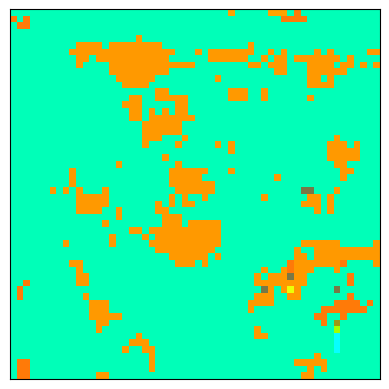

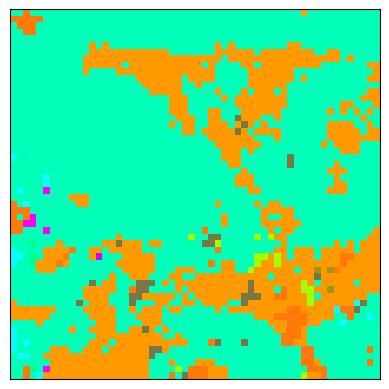

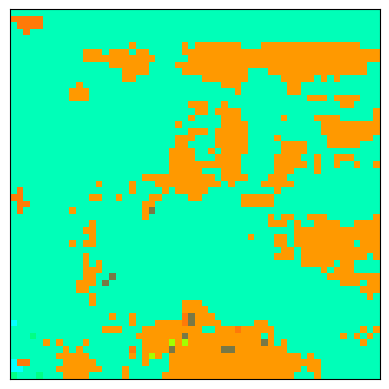

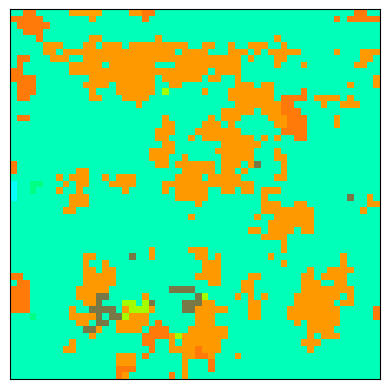

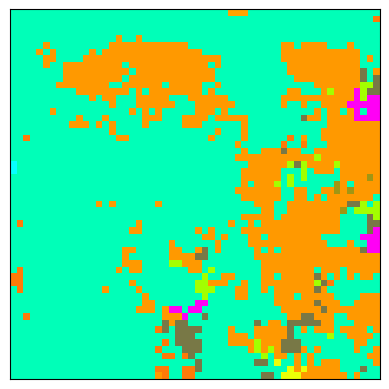

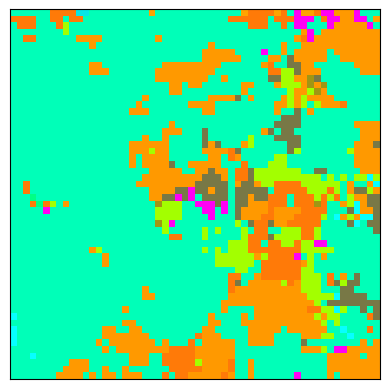

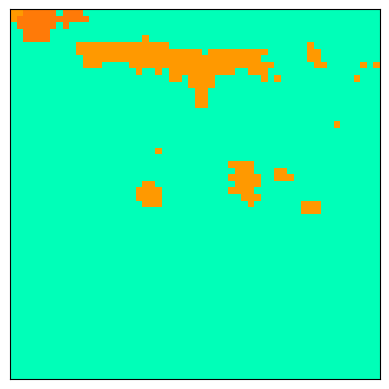

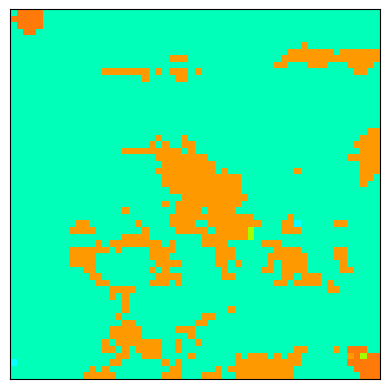

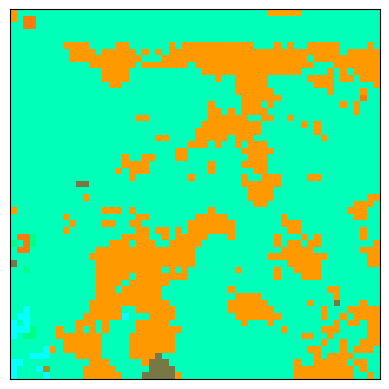

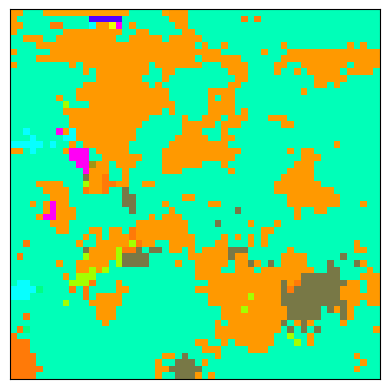

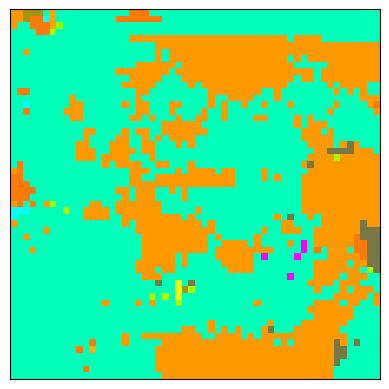

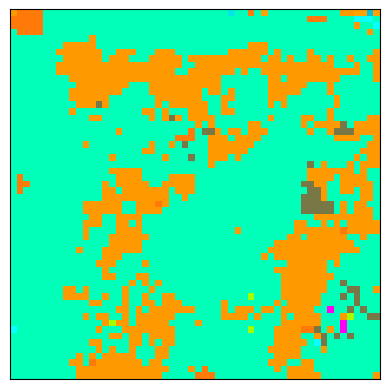

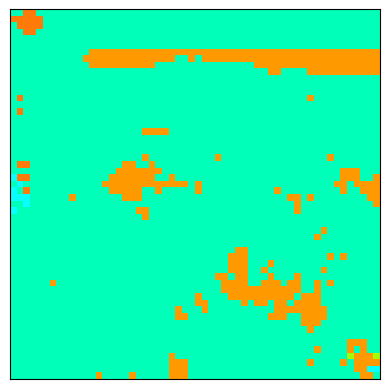

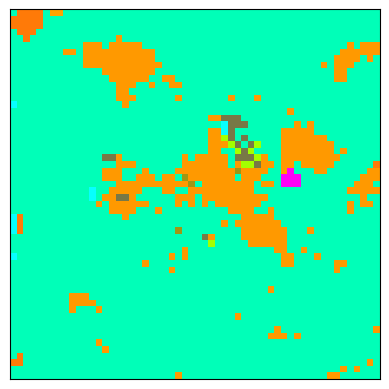

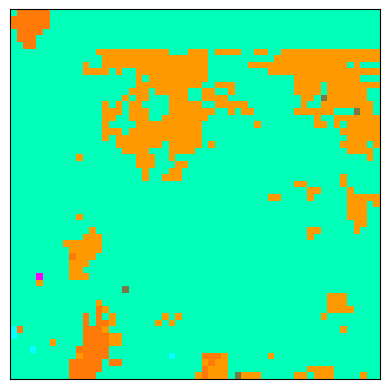

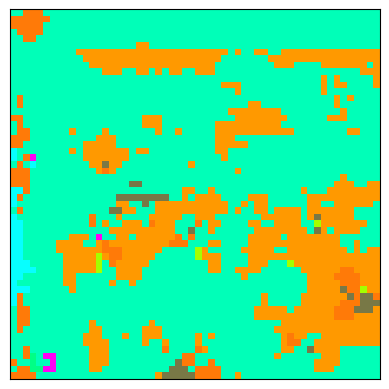

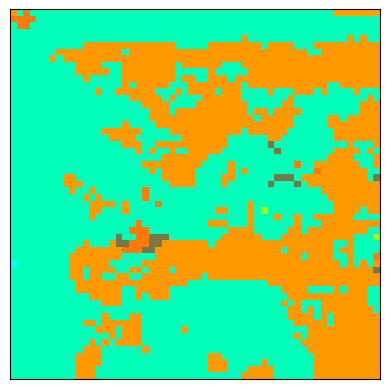

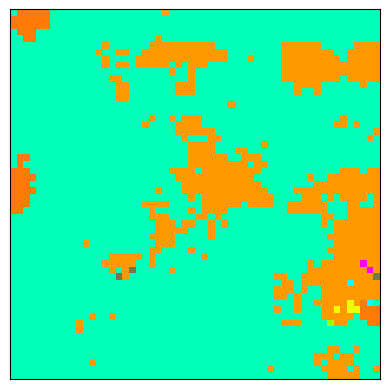

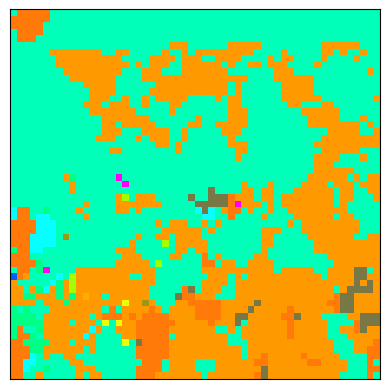

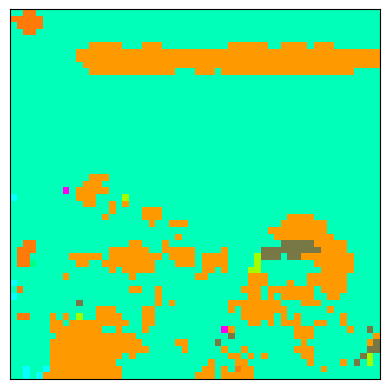

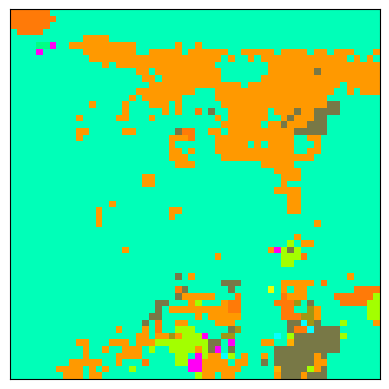

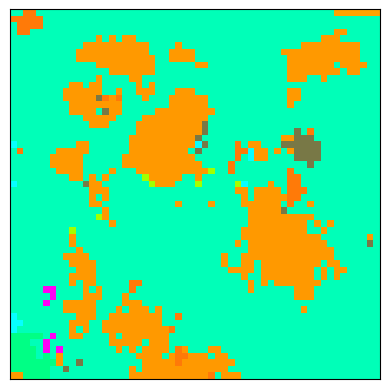

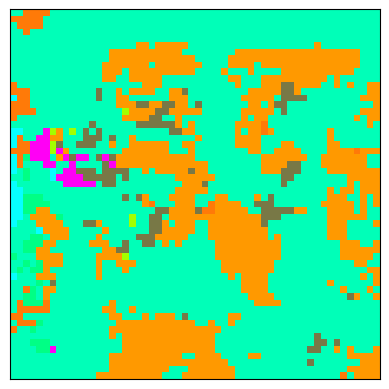

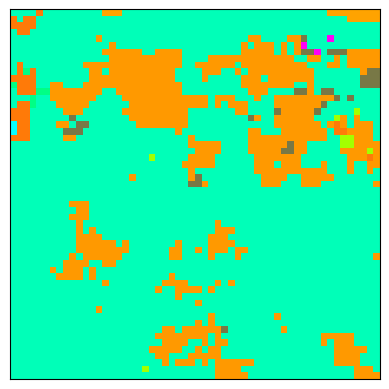

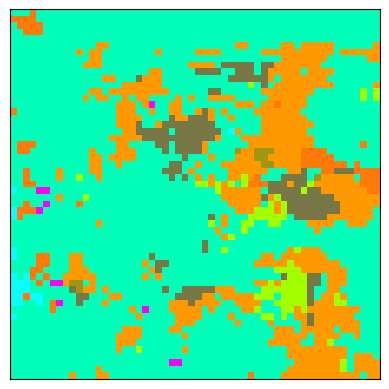

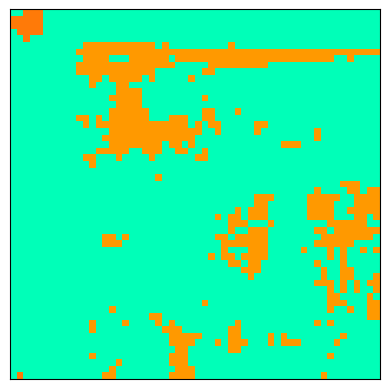

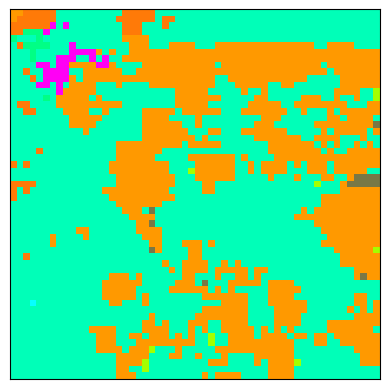

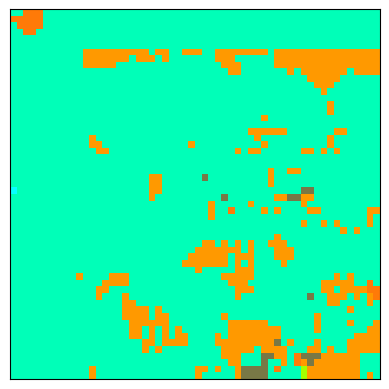

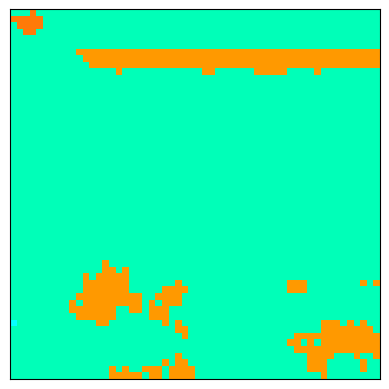

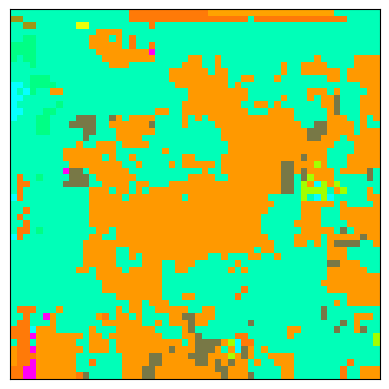

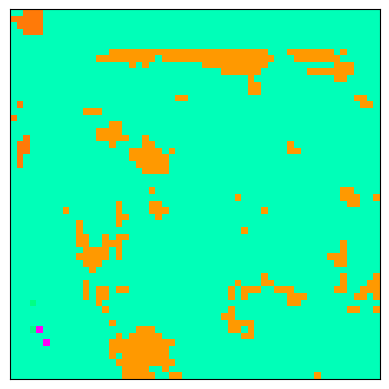

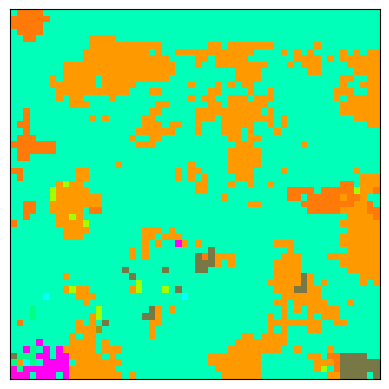

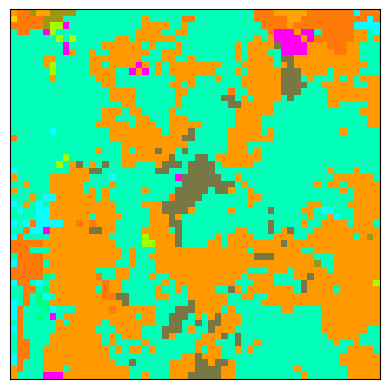

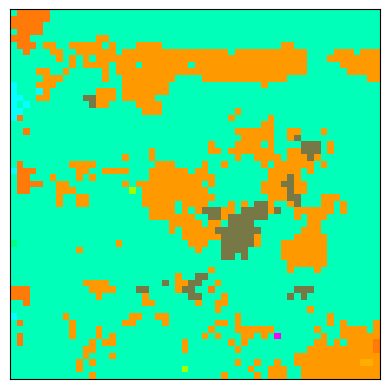

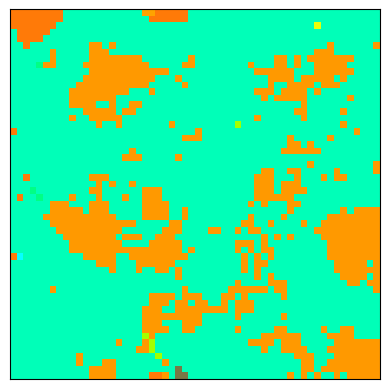

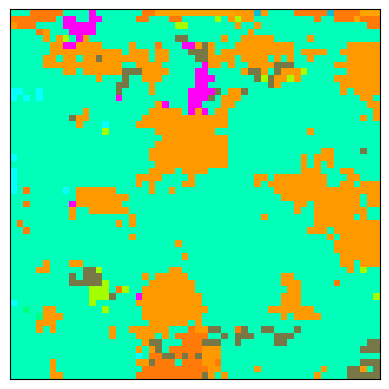

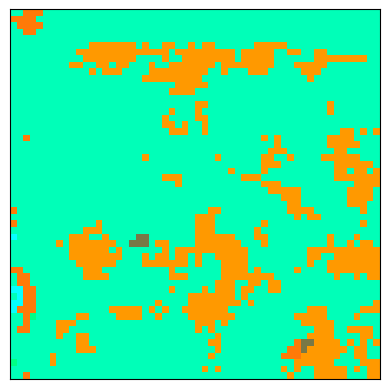

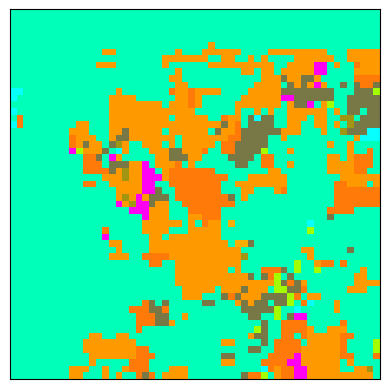

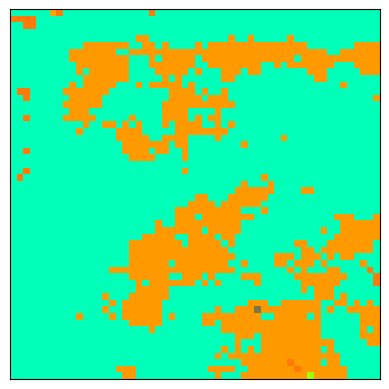

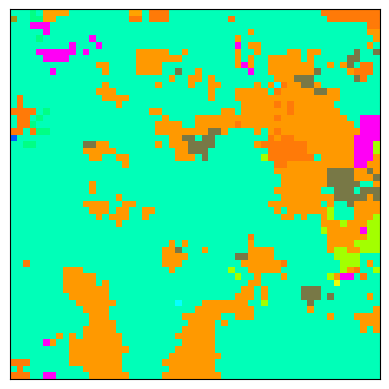

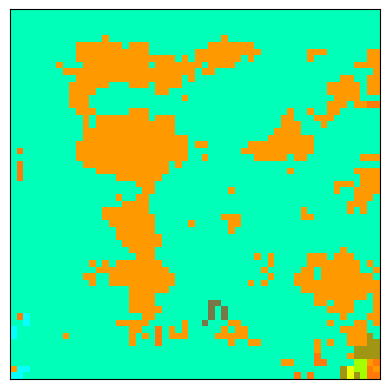

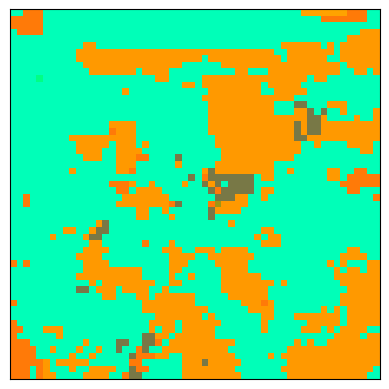

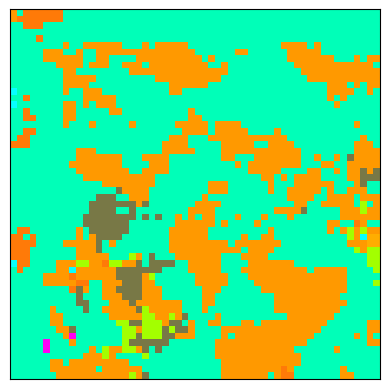

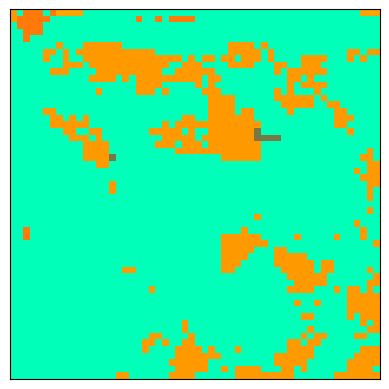

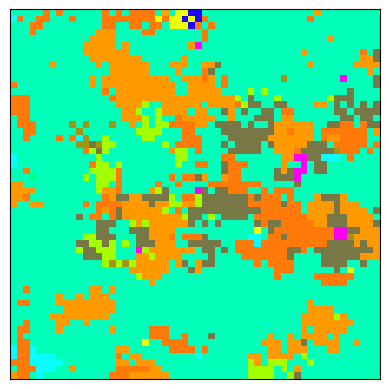

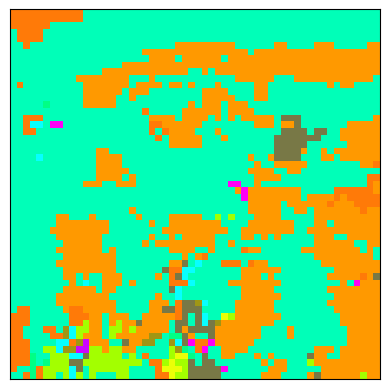

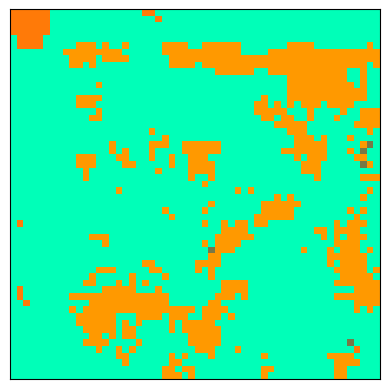

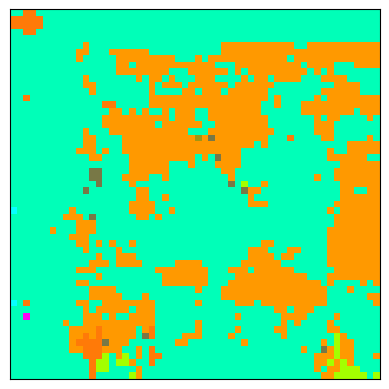

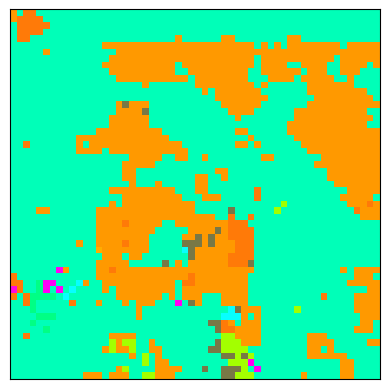

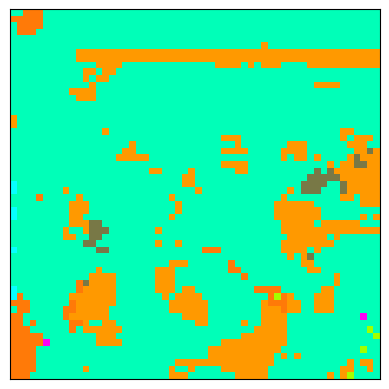

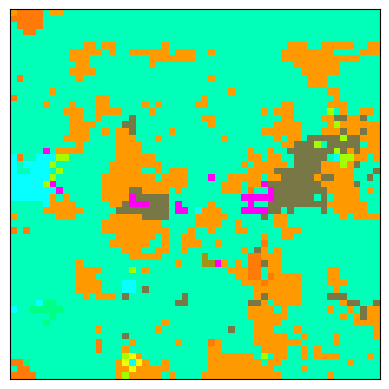

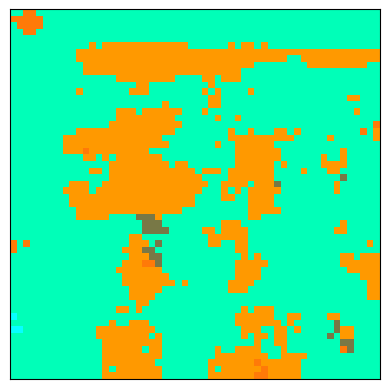

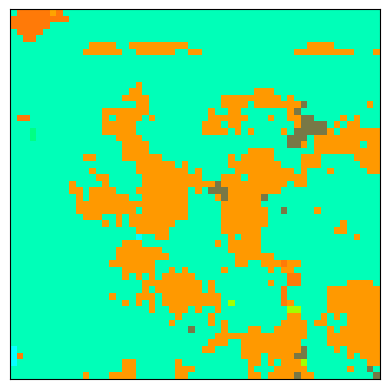

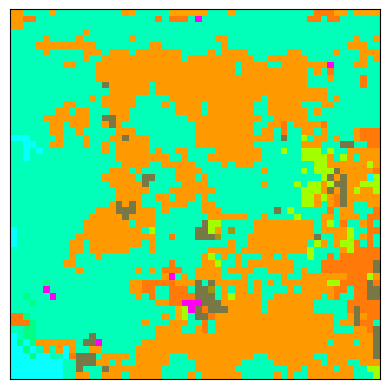

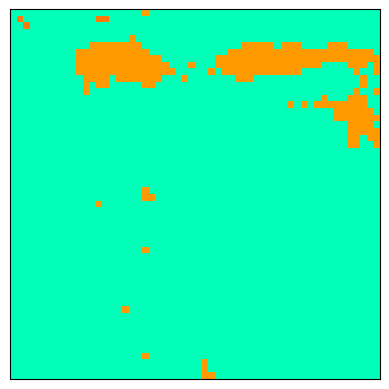

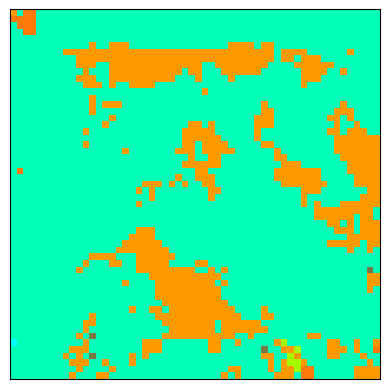

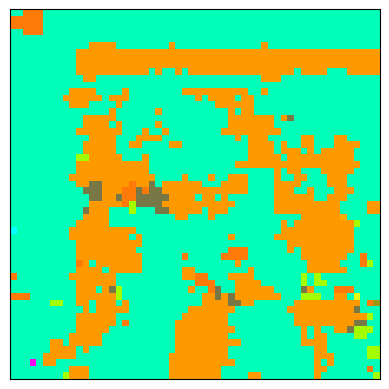

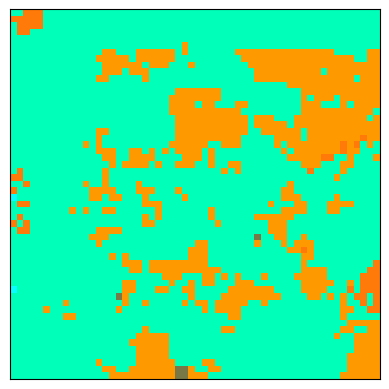

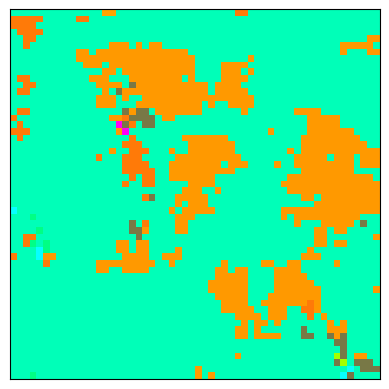

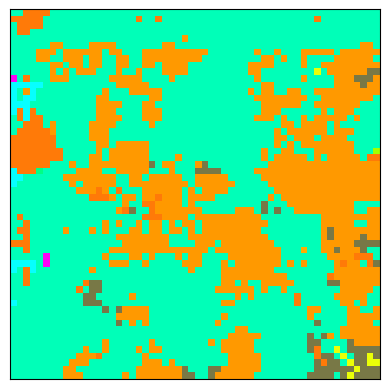

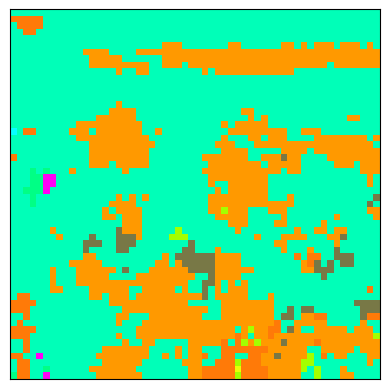

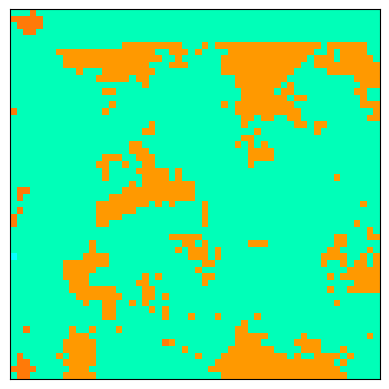

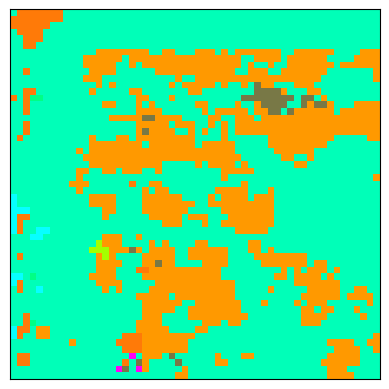

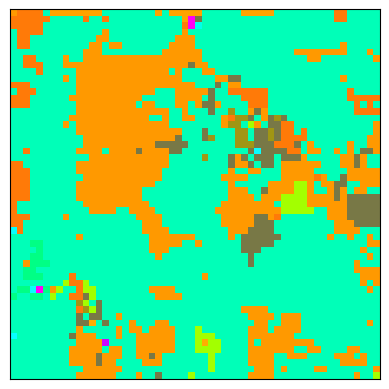

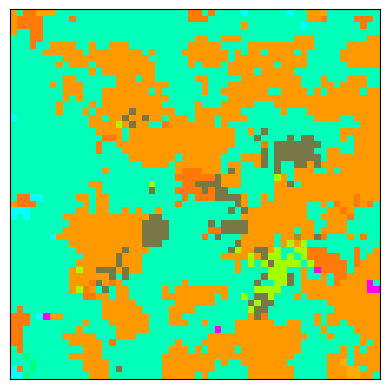

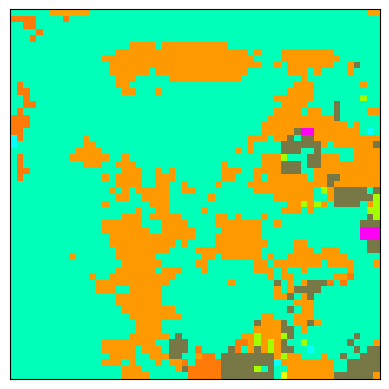

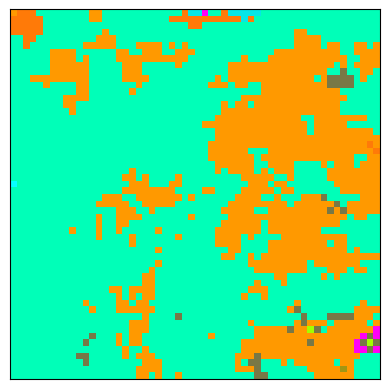

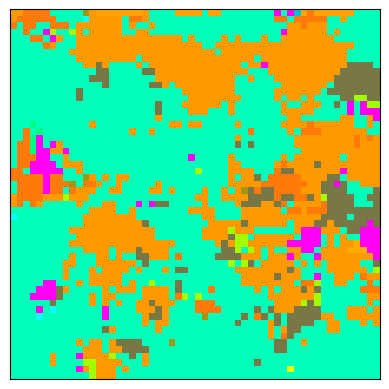

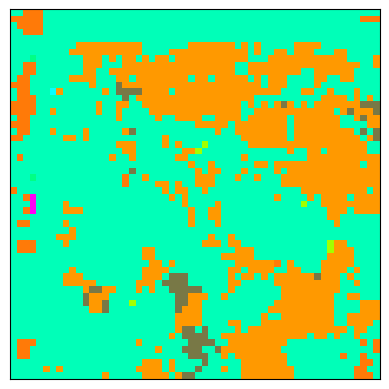

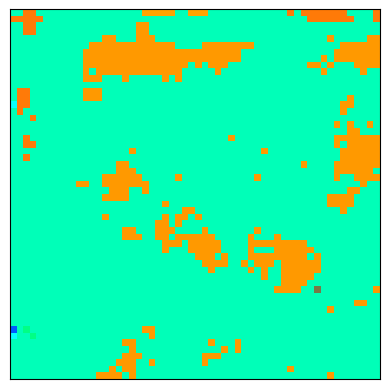

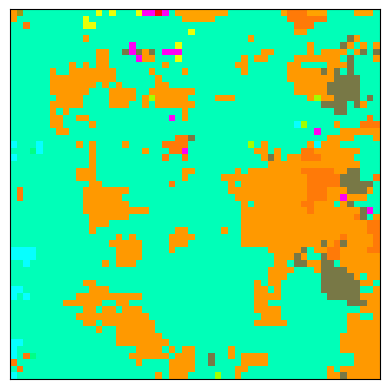

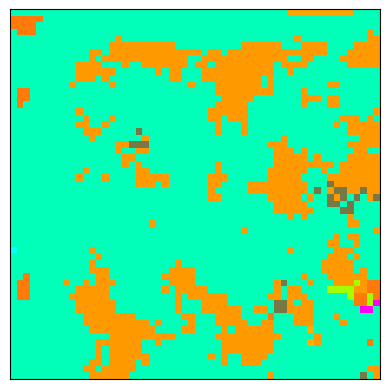

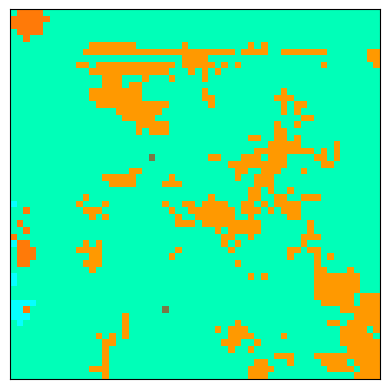

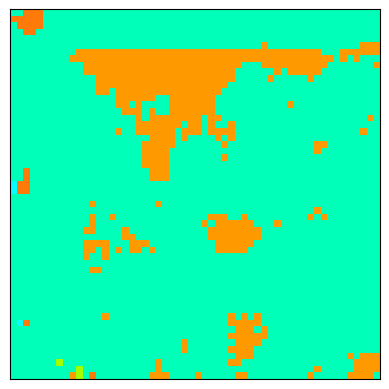

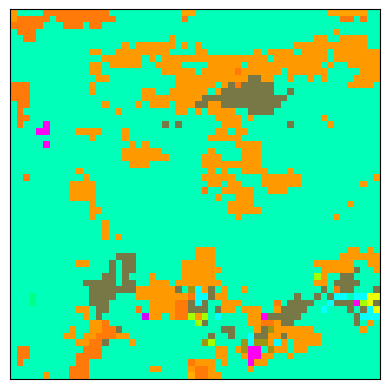

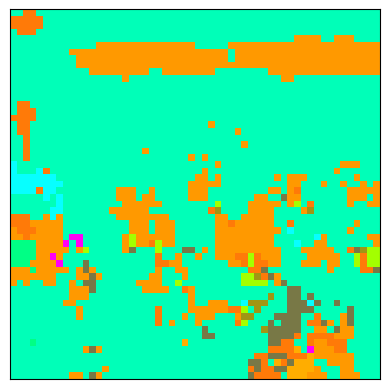

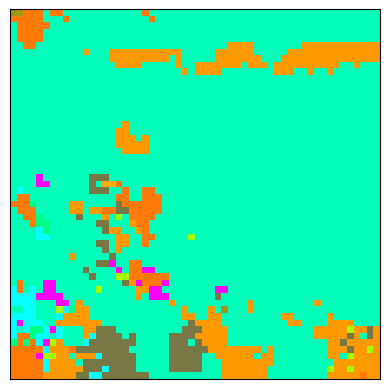

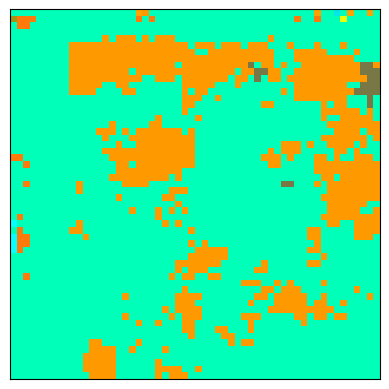

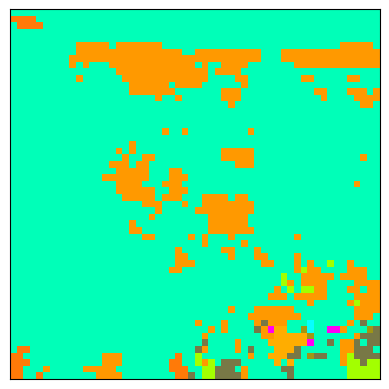

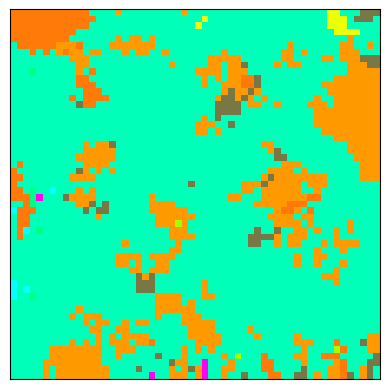

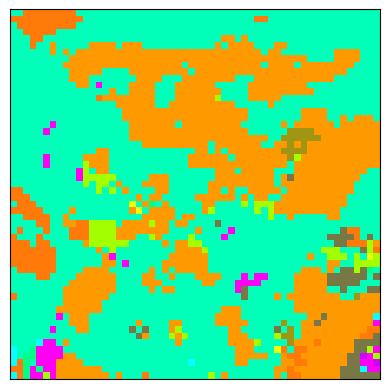

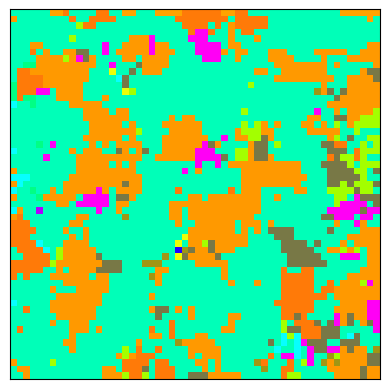

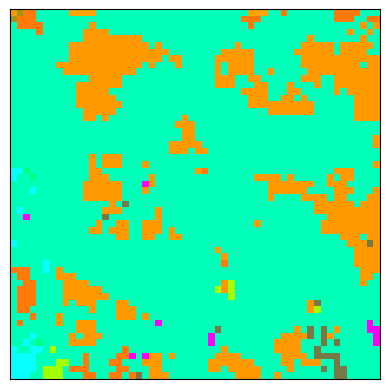

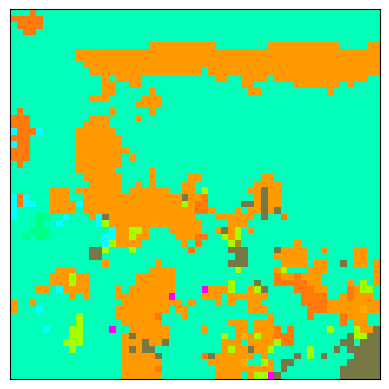

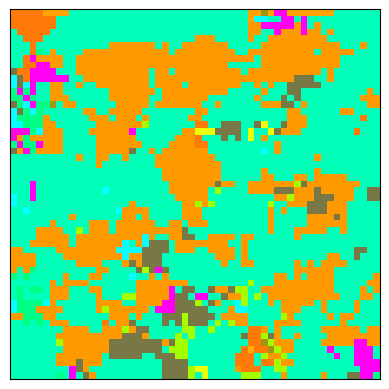

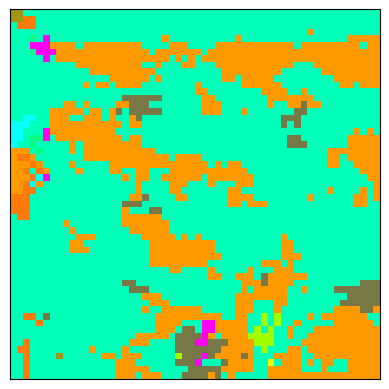

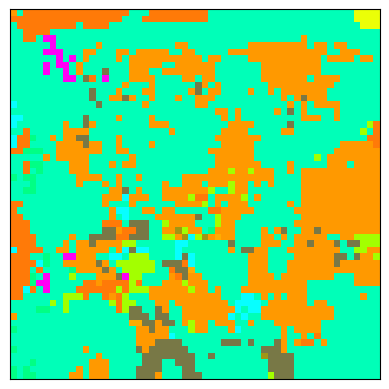

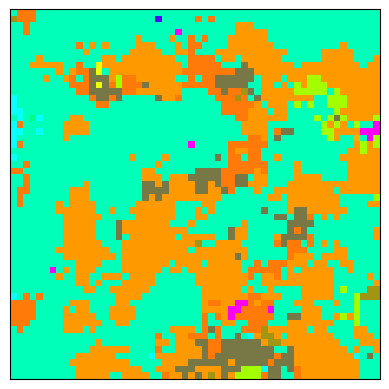

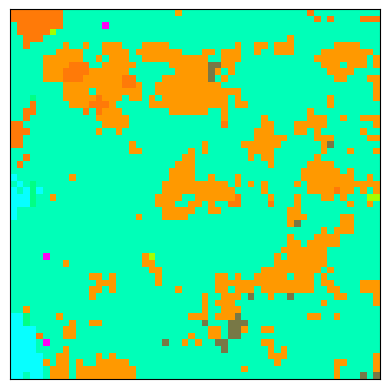

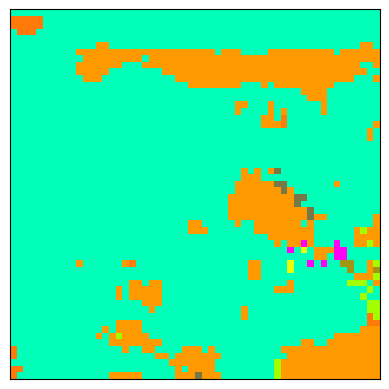

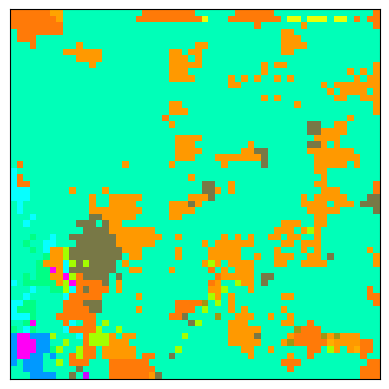

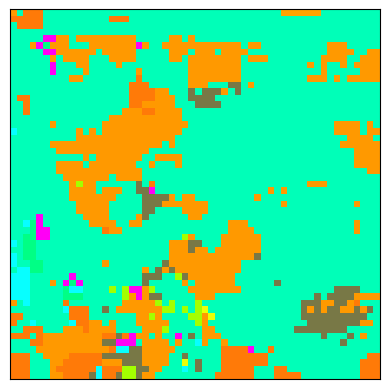

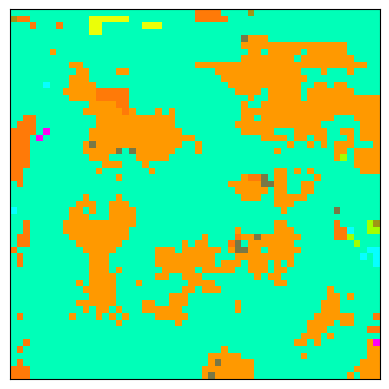

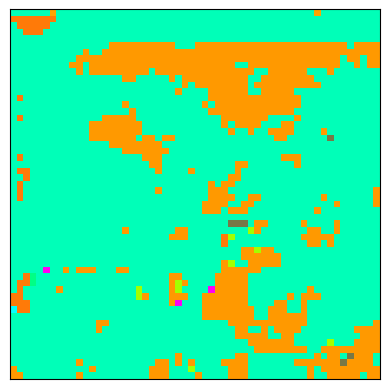

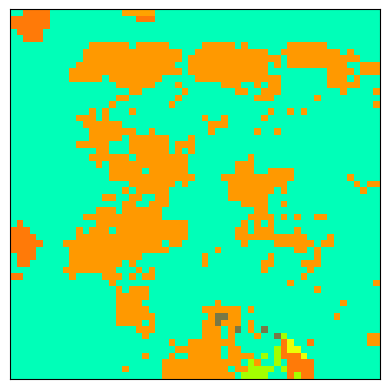

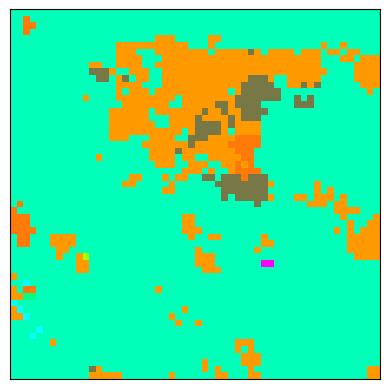

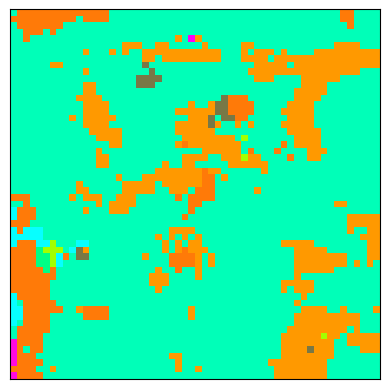

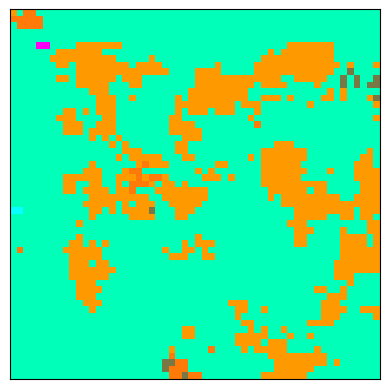

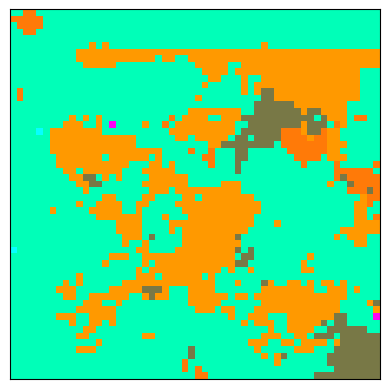

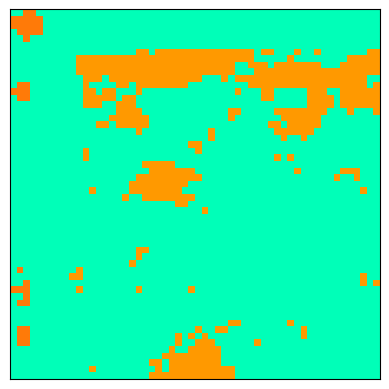

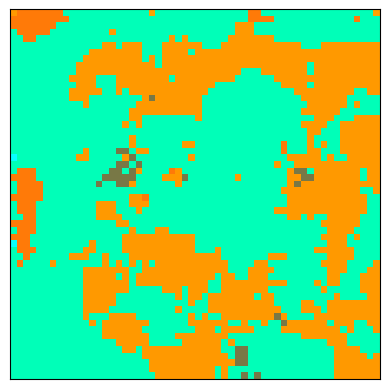

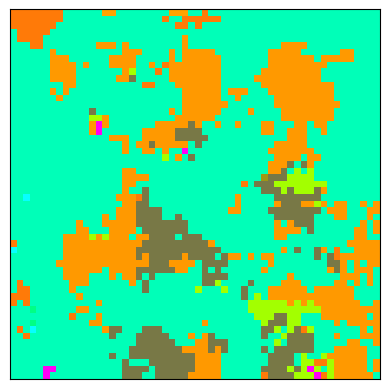

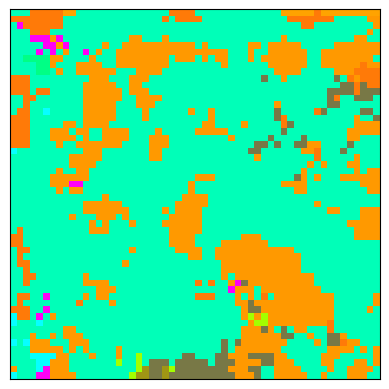

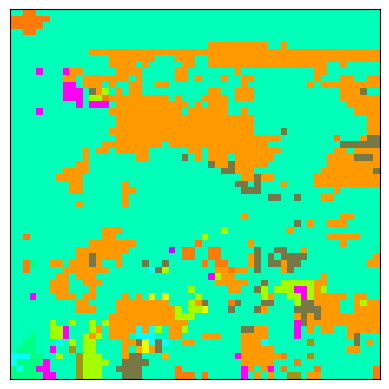

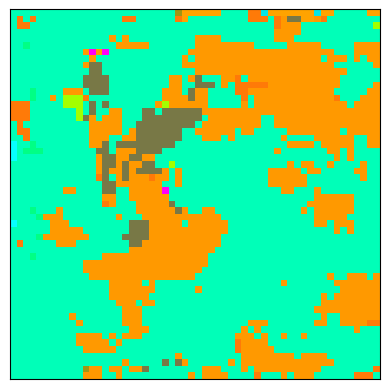

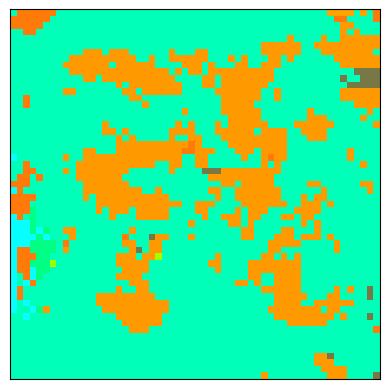

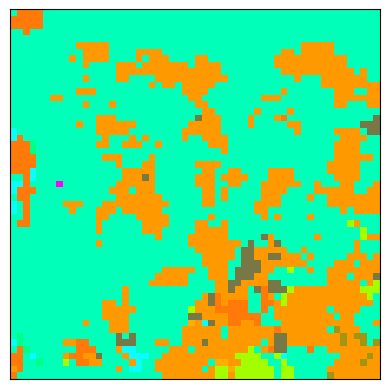

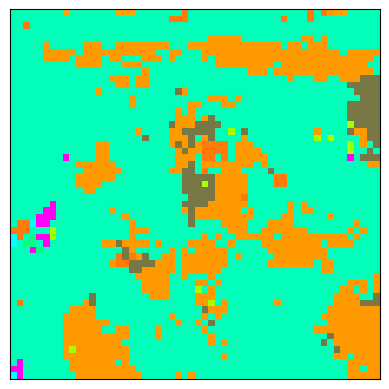

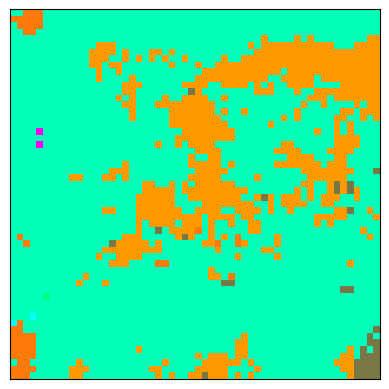

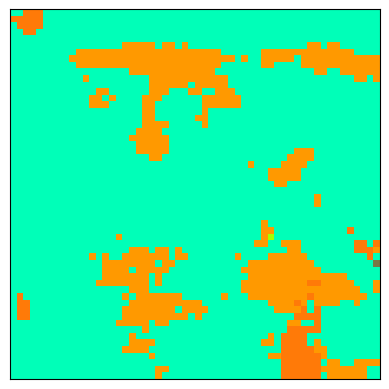

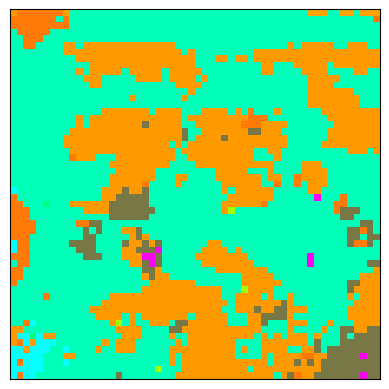

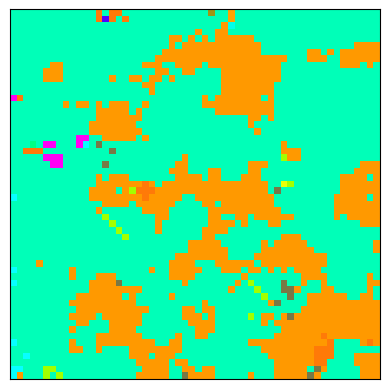

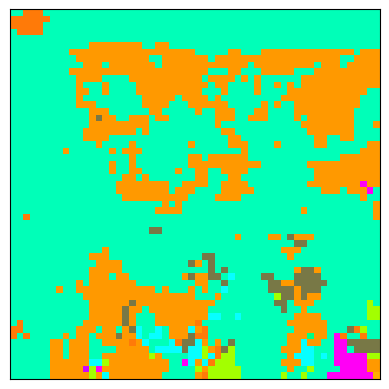

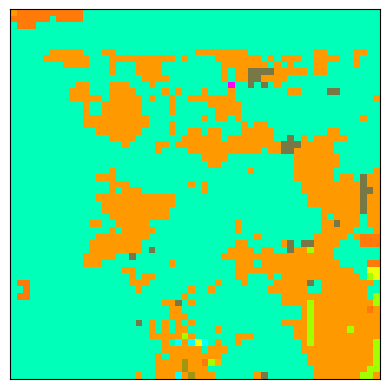

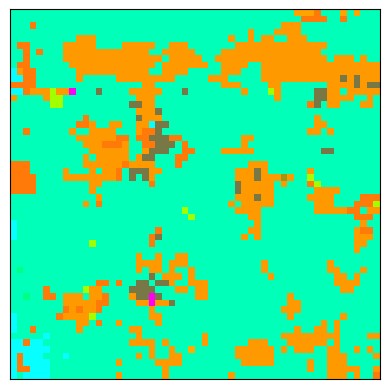

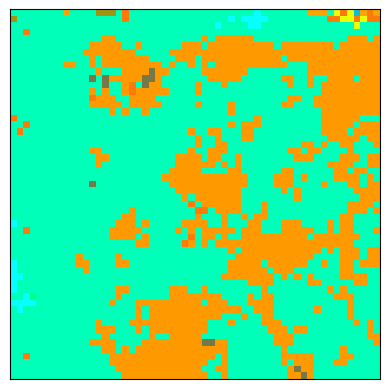

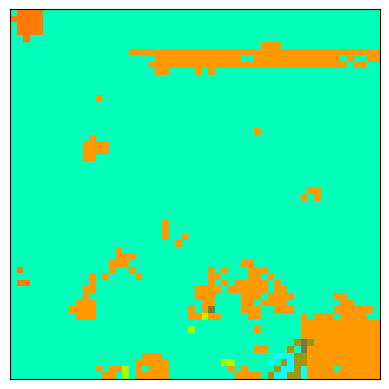

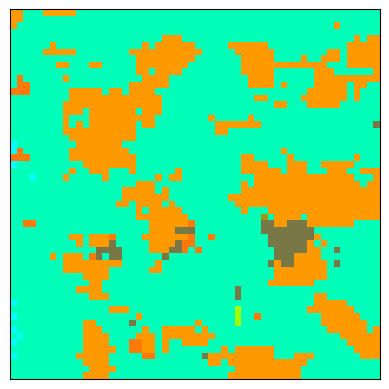

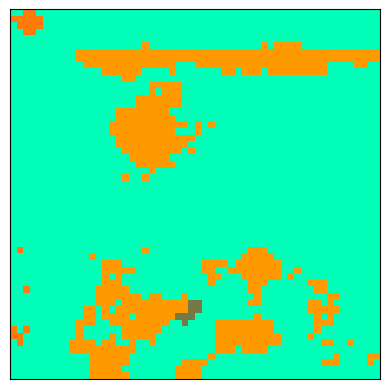

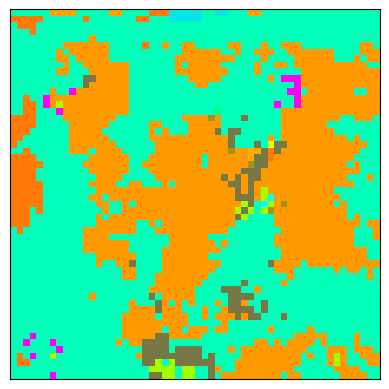

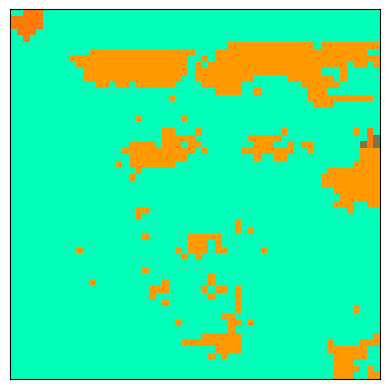

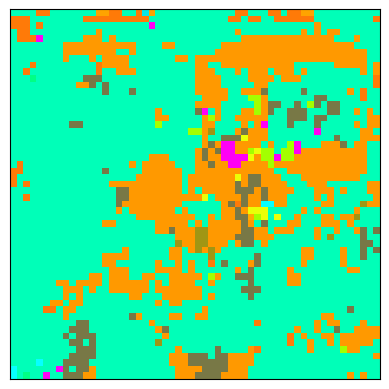

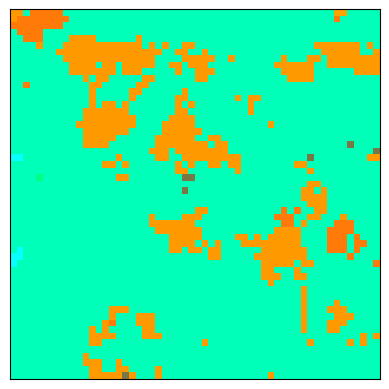

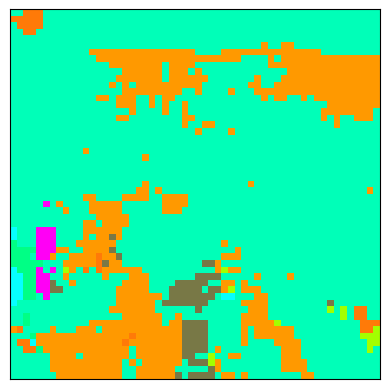

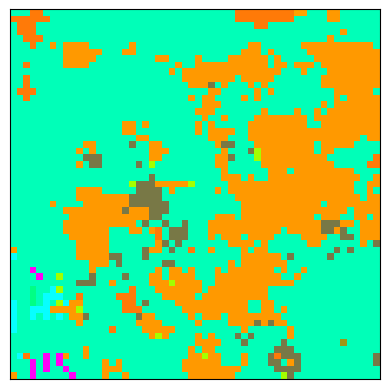

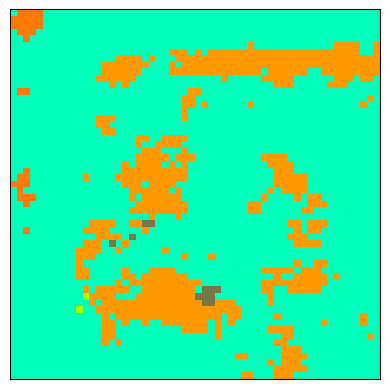

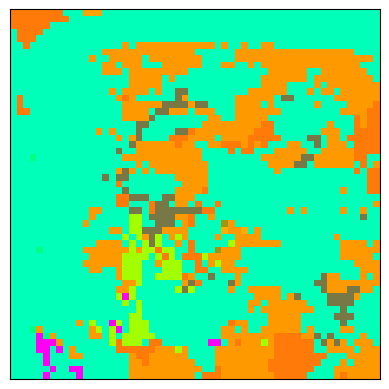

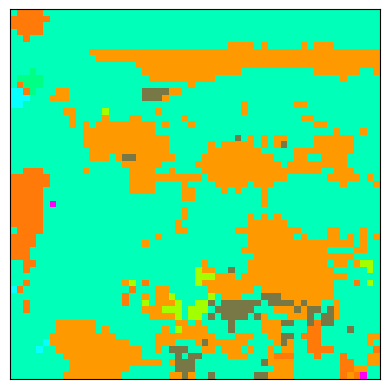

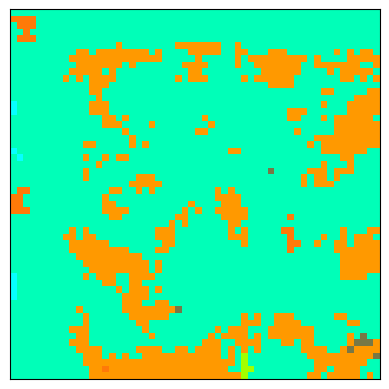

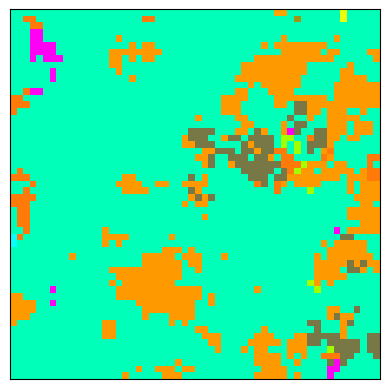

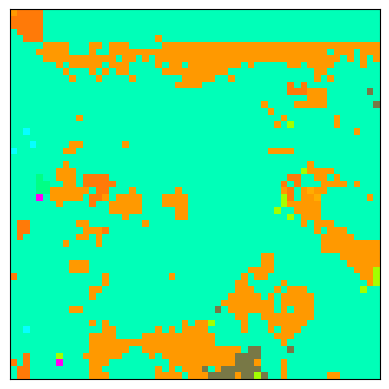

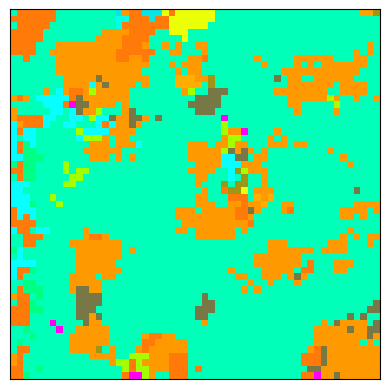

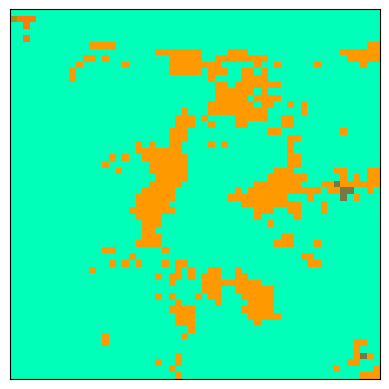

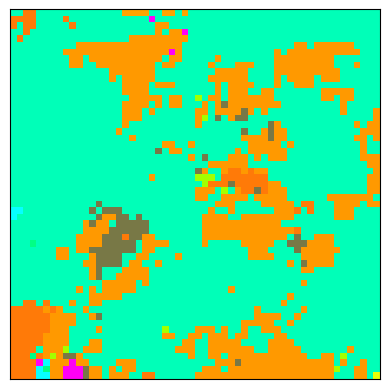

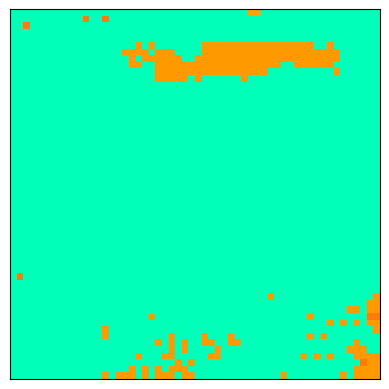

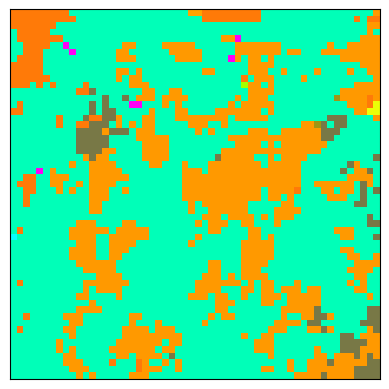

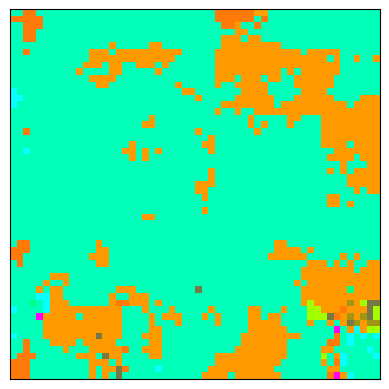

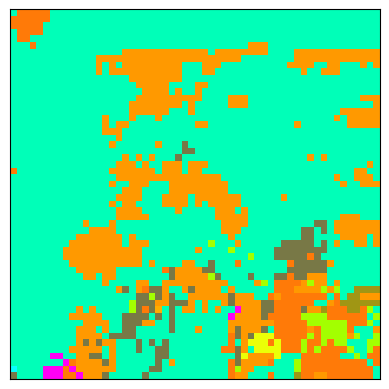

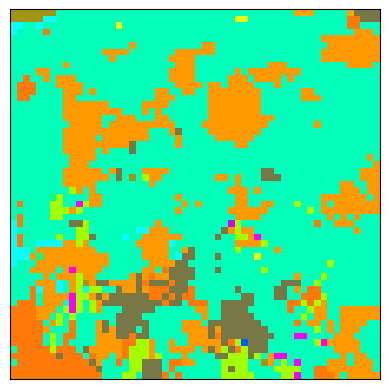

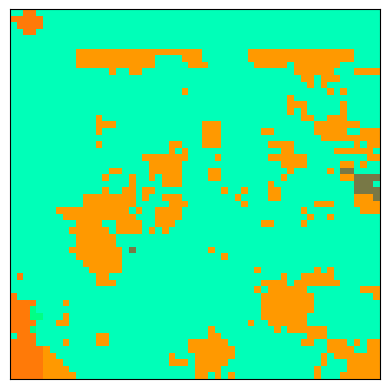

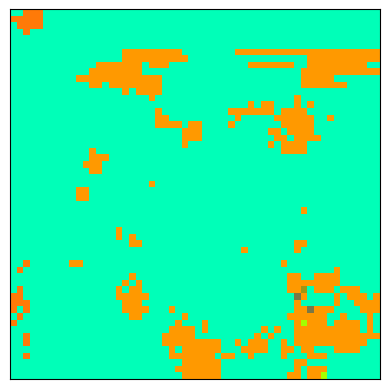

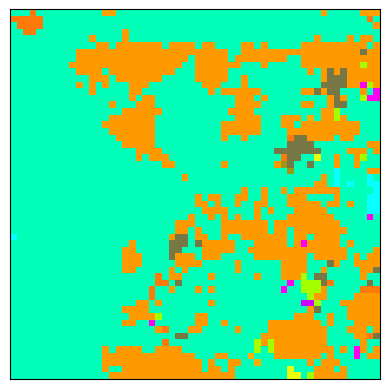

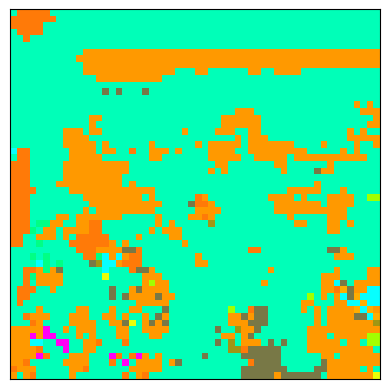

In [24]:
from semseg.datasets import *

#model = model.to(device)
predictions = []
start = time.time()
#print('test')
# Use torch.no_grad() to disable gradient computation during testing
with torch.no_grad():

    for images, labels in train_loader:
        # Move the data to the desired device
        #print(images.shape)
        images = images.permute(0,3,1,2).to(device)
        #images = images.permute(2,0,1).to(device)
        #images = images [None, :, :, :]
        #print(images.shape)
        
        #print(images.shape)
        #labels = labels.to(device)

        # Forward pass to get the predictions
        with torch.inference_mode():
          prediction = model(images)
        #print(prediction)
        prediction = prediction.softmax(1).argmax(1).to(int)
        #prediction = prediction.round().to(int)
        #print(prediction.shape)
        un = prediction.unique()
        #print(un)
        palette = eval('ADE20K').PALETTE.to(device)
        prediction_map = palette[prediction].squeeze().to(torch.uint8)
        #print(type(prediction_map))
        show_image(prediction_map)
        predictions.append(prediction_map)
        
end = time.time()
print(end-start)